# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Построим модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#установим  LightGBM

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
#установим  CatBoost

In [4]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns #построение графиков

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor #создание константной модели (среднее, медиана и др)

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #кросс-валидация
from sklearn.metrics import make_scorer #для написания ручной оценки

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

#раздел upsampling
from sklearn.utils import shuffle

#библиотека LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

#библиотека CatBoost
import catboost as cb
from catboost import CatBoostRegressor

In [6]:
#check version
print(lgb.__version__) 
print(cb.__version__)

3.3.1
1.0.3


In [7]:
#Уберем предупреждения и ограничения:

#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.if _joblib.__version__ >= LooseVersion('0.12'):
import warnings
warnings.filterwarnings('ignore')

#SettingWithCopy 
#при записи изменённых признаков в исходный датафрейм (особенности поведения sklearn и pandas)
pd.options.mode.chained_assignment = None

#отключим предупреждением библиотеки sklearn при обучении логистической регрессии, 
#укажем аргумент solver='liblinear' (англ. solver «алгоритм решения»; library linear, «библиотека линейных алгоритмов»)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [8]:
#загрузим датасет
try:
    data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])   
except FileNotFoundError:
    data = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

data_raw = data #данные для проверкиработы регрессов с категориальными признками
    
display(data.head())
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [10]:
#узнаем максимальную дату регистрации для последующей фильтрации по RegistrationYear чтобы исключить машины "из будущего", т.е удалим RegistrationYear которые старше даты создания анкеты
print(data['DateCreated'].max())

2016-04-07 00:00:00


In [11]:
#удалим столбцы не являющиеся ценными для обучения модели
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

<AxesSubplot:>

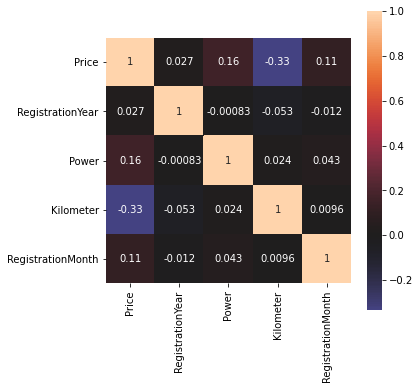

In [12]:
#проверим корреляцию признаков
plt.show()
plt.figure(figsize = (5.5, 5.5))
sns.heatmap(data.corr(), annot=True, fmt='.2g', square=True, center= 0)

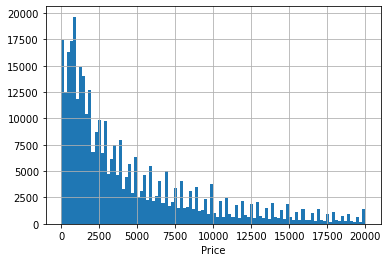

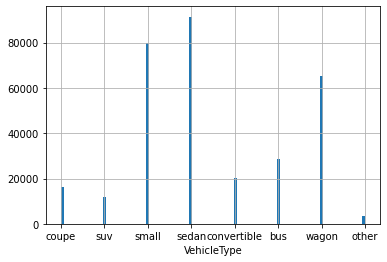

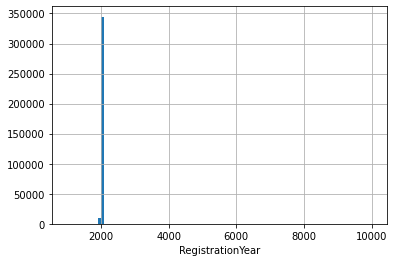

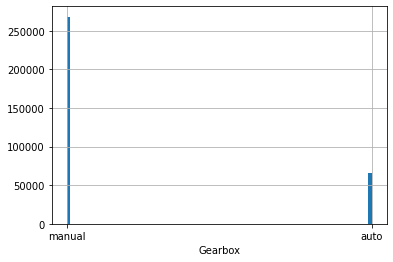

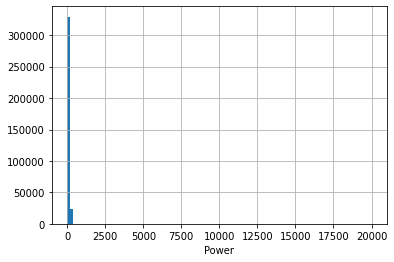

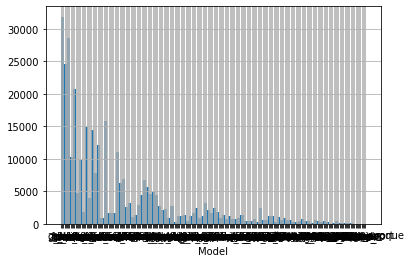

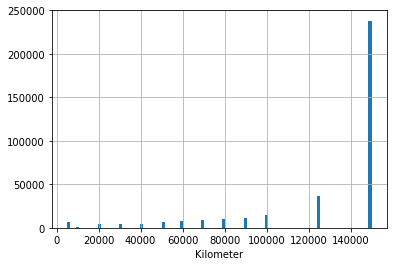

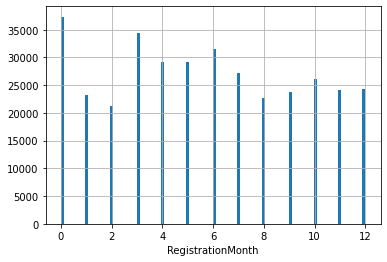

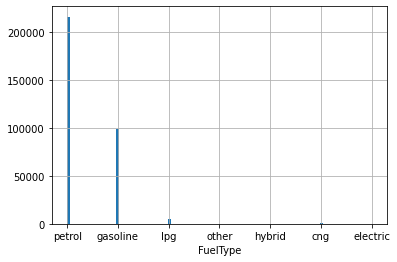

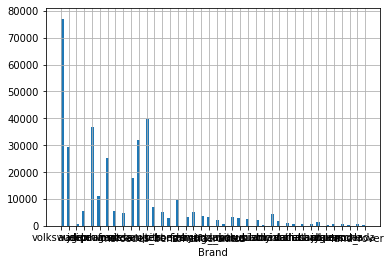

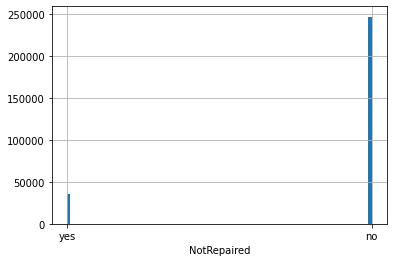

In [13]:
#проверим распределение 
#строки/объекты с нулевыми значениями цены - необходимо будет удалить 
columns = list(data.columns)

for column in columns:
    plt.figure()
    plt.xlabel(column)
    data[column].hist(bins=100)
    plt.show()

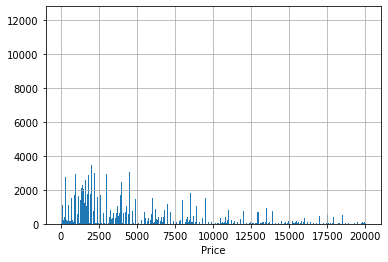

In [14]:
columns = ['Price']

for column in columns:
    plt.figure()
    plt.xlabel(column)
    data[column].hist(bins=1000)
    plt.show()

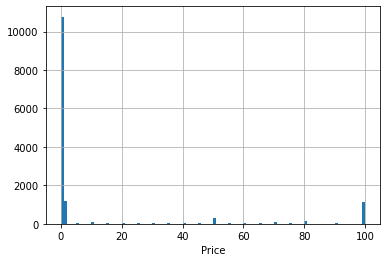

In [15]:
#проверим распределение цены детальнее
plt.figure()
plt.xlabel(column)
data['Price'].hist(range=(0, 100), bins=100)
plt.show()

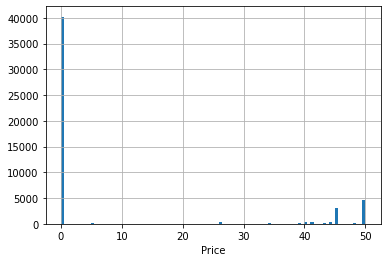

In [16]:
#проверим распределение мощности детальнее
plt.figure()
plt.xlabel(column)
data['Power'].hist(range=(0, 50), bins=100)
plt.show()

In [17]:
#удалим строки/объекты с нулевыми значениями цены, тк цена - наш целевой признак

print(data.shape[0])
#data = data.dropna(subset=['Price']) 
data = data[data.Price > 0]
print(data.shape[0])

354369
343597


In [18]:
#
display(data.isna().sum())
data.describe()

Price                    0
VehicleType          33750
RegistrationYear         0
Gearbox              17355
Power                    0
Model                17521
Kilometer                0
RegistrationMonth        0
FuelType             29459
Brand                    0
NotRepaired          65866
dtype: int64

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000
mean,4555.121974,2004.089797,111.000192,128337.616452,5.777891
std,4515.058553,78.413225,188.177974,37521.047429,3.698186
min,1.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [19]:
print(data.shape[0])

columns = list(data.columns)
for column in columns:
    data = data.loc[data[column] != 0]
data = data.dropna(subset=columns)


data = data.loc[data['Price'] >= 50]
data = data.loc[data['RegistrationYear'] >= 1970]
data = data.loc[data['RegistrationYear'] <= 2016]
data = data.loc[data['Power'] >= 20]
data = data.loc[data['Power'] <= 3500] # 3500 лс у данного грузовика (https://motor.ru/news/thor24-15-11-2019.htm)
    
print(data.shape[0])

display(data.isna().sum())
data.describe()

343597
226906


Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,226906.000000,226906.000000,226906.000000,226906.00000,226906.000000
mean,5356.738328,2003.253700,123.915335,126895.03583,6.374909
std,4737.352479,5.829147,60.841103,37040.57541,3.353531
min,50.000000,1970.000000,20.000000,5000.00000,1.000000
25%,1600.000000,1999.000000,82.000000,125000.00000,3.000000
50%,3750.000000,2004.000000,116.000000,150000.00000,6.000000
75%,7850.000000,2007.000000,150.000000,150000.00000,9.000000
max,20000.000000,2016.000000,2729.000000,150000.00000,12.000000


In [20]:
#Наши данные содержат категориальные признаки. Принадлежность к категории к примеру логистическая регрессия вычисляет по формуле, состоящей из признаков. 
#Они могут быть только численные. Поэтому применим технику прямого кодирования One-Hot Encoding, OHE. 
#Она подходит для решения нашей задачи: работает со всеми моделями.
#Применим технику прямого кодирования One-Hot Encoding (OHE)

#чтобы не попасть в dummy trap , применим аргумент drop_first функции pd.get_dummies(). 
data_ohe = pd.get_dummies(data, drop_first=True)

In [21]:
#извлечем целевой признак и признаки, создадим выборки
target = data_ohe['Price']
features = data_ohe.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

#проверим размеры выборок
samples = [features_train, features_valid, target_train, target_valid]
for sample in samples:
    print(sample.shape)

(170179, 305)
(56727, 305)
(170179,)
(56727,)


In [22]:
features.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
3,2001,75,150000,6,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

 ### Вывод
- Загрузили датасет,
- Выявили слабую связь по шкале Чеддока между признаками: Пробег и Цена, остальные связи относятся к очень слабым.

## Обучение моделей
- Обучим модели. Для каждой попробуем различные гиперпараметры.

### RandomForestRegressor

In [23]:
%%time

#объявим классификатор не внося параметров
model = RandomForestRegressor()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (3, 5, 1),
              'max_depth': range (1, 5, 2),
              'min_samples_leaf': range (1, 3),
              'min_samples_split': range (2, 5, 1)
            }

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = RandomizedSearchCV(model, parametrs, cv=3, n_jobs = 3, 
                          scoring='neg_root_mean_squared_error', verbose=True)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'RandomForestRegressor.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'random_state': 12345, 'n_estimators': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 3}
-2782.0874367934034
CPU times: user 2.9 s, sys: 478 ms, total: 3.38 s
Wall time: 55.8 s


['RandomForestRegressor.joblib']

### LGBMRegressor

In [ ]:
%%time

#объявим классификатор
model = LGBMRegressor(verbosity= -1)

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = {'random_state': range (12345, 12346, 10),
             'reg_lambda':[1,3,6],
             'learning_rate':[0.001, 0.01,0.1]                                 
            }

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=3, n_jobs = 3, scoring='neg_root_mean_squared_error', verbose=3)

grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'LGBMRegressor.joblib')

### CatBoostRegressor

In [ ]:
%%time

#объявим классификатор
model = CatBoostRegressor()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, поэтому поставим random_state (12345, 12346, 10)
parametrs = {'random_state': range (12345, 12346, 10),
             'reg_lambda':[1,3,6],
             'learning_rate':[0.001, 0.01,0.1]                           
            }

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=3, n_jobs = 3, scoring='neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'CatBoostRegressor.joblib')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0:	learn: 4736.1508018	total: 183ms	remaining: 3m 2s
1:	learn: 4732.8645620	total: 200ms	remaining: 1m 39s
2:	learn: 4729.5582012	total: 280ms	remaining: 1m 33s
3:	learn: 4726.2552118	total: 298ms	remaining: 1m 14s
4:	learn: 4722.9211974	total: 379ms	remaining: 1m 15s
5:	learn: 4719.6135245	total: 397ms	remaining: 1m 5s
6:	learn: 4716.3121295	total: 491ms	remaining: 1m 9s
7:	learn: 4713.0415312	total: 586ms	remaining: 1m 12s
8:	learn: 4709.8267771	total: 682ms	remaining: 1m 15s
9:	learn: 4706.5762506	total: 699ms	remaining: 1m 9s
10:	learn: 4703.3084165	total: 789ms	remaining: 1m 10s
11:	learn: 4700.0263373	total: 882ms	remaining: 1m 12s
12:	learn: 4696.7930695	total: 976ms	remaining: 1m 14s
13:	learn: 4693.5591474	total: 1.07s	remaining: 1m 15s
14:	learn: 4690.3570873	total: 1.09s	remaining: 1m 11s
15:	learn: 4687.1888655	total: 1.11s	remaining: 1m 8s
16:	learn: 4683.9749513	total: 1.2s	remaining: 1m 9s
17:	learn: 4680.754873

### Вывод
- обучили модели
- сохранили модели для вызова в следующем пункте работы

## Анализ моделей
- Проанализируем скорость работы и качество моделей.

### RandomForestRegressor

In [ ]:
%%time
model = joblib.load('RandomForestRegressor.joblib')

predicted_valid = model.predict(features_valid)
rmse_rf = (mean_squared_error(target_valid, predicted_valid))**0.5
print("RMSE =", rmse_rf)

### LGBMRegressor

In [ ]:
%%time
model = joblib.load('LGBMRegressor.joblib')

predicted_valid = model.predict(features_valid)
rmse_lgbm = (mean_squared_error(target_valid, predicted_valid))**0.5
print("RMSE =", rmse_lgbm)

### CatBoostRegressor

In [ ]:
%%time
model = joblib.load('CatBoostRegressor.joblib')

predicted_valid = model.predict(features_valid)
rmse_catboost = (mean_squared_error(target_valid, predicted_valid))**0.5
print("RMSE =", rmse_catboost)

In [ ]:
rmse = [
    [rmse_rf, '20.4 s', '104 ms'],
    [rmse_lgbm, '27.3 s', '302 ms'],
    [rmse_catboost, '3min 35s', '109 ms'],
]
title = ['RMSE, euro', '~training time', '~predicting time'] 
regressor = ['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor']

world_map = pd.DataFrame(data=rmse, index=regressor, columns=title) # создаём таблицу и сохраняем её в переменную

display(world_map) # выводим таблицу
print('* ~time - время (для процессора: 4 ядра (2,8ГГц), 8 потоков) примерно тк при повторном пересчете меняется')

### Вывод
- лучшая модель по скорости обучения - RandomForestRegressor
- лучшая модель по скорости предсказывания - RandomForestRegressor
- лучшая модель по RMSE - CatBoostRegressor

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей